In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

# Load the data
df = pd.read_csv('ADResearch_FY26Task_dataset.csv')

# Create categorical outcome
df['employment_outcome'] = df['employment']

# Define the four factors
df['skills_score'] = df['grade']
df['networks_score'] = df[['post_netdiv_avg', 'post_netstren_avg']].mean(axis=1)
df['confidence_score'] = df[['post_cse_avg', 'post_fit_avg',
                                'post_jse_avg', 'post_nse_avg']].mean(axis=1)
df['experience_score'] = df['internship']

factor_scores = ['skills_score', 'networks_score', 'confidence_score', 'experience_score']

In [ ]:
# STEP 1: PREPARE DATASET (ALL ANALYSES USE THIS)
# ============================================================================

print("\n" + "=" * 80)
print("STEP 1: PREPARING DATASET")
print("=" * 80)

# Replace missing factor scores with NaN (they are already NaN, this is just for clarity)
# For 'employment_outcome', we will keep all rows and handle missing in analysis if needed
data_prepared = df[factor_scores + ['employment_outcome']].copy()

print(f"\nOriginal dataset: {len(df)} observations")
print(f"Prepared dataset: {len(data_prepared)} observations")
print(f"Missing values per factor:")
print(data_prepared[factor_scores].isnull().sum())
print(f"Missing values in employment outcome: {data_prepared['employment_outcome'].isnull().sum()}")

print("\nPrepared Dataset Summary Statistics (including NaNs):")
print(data_prepared[factor_scores].describe())


STEP 1: PREPARING DATASET

Original dataset: 1244 observations
Prepared dataset: 1244 observations
Missing values per factor:
skills_score         26
networks_score      407
confidence_score    334
experience_score    413
dtype: int64
Missing values in employment outcome: 0

Prepared Dataset Summary Statistics (including NaNs):
       skills_score  networks_score  confidence_score  experience_score
count   1218.000000      837.000000        910.000000        831.000000
mean      87.710181        5.844922          5.194089          1.200963
std        8.932721        1.044317          0.794108          1.834554
min        4.000000        1.000000          1.441176          0.000000
25%       84.000000        5.166667          4.709191          0.000000
50%       89.500000        6.000000          5.250000          1.000000
75%       94.000000        6.833333          5.832721          2.000000
max      101.000000        7.000000          6.500000         20.000000


# STEP 2: ANALYSIS WITH MULTI-CATEGORICAL OUTCOME (ANOVA)
# ============================================================================

In [ ]:
print("\n" + "=" * 80)
print("STEP 2: ANALYSIS WITH MULTI-CATEGORICAL OUTCOME (ANOVA)")
print("=" * 80)

# We will use ANOVA to compare means across the different employment outcomes

anova_results = []

for factor in factor_scores:
    # Create a list of arrays, one for each outcome category, dropping NaNs within each group
    data_by_outcome = [group[factor].dropna() for name, group in data_prepared.groupby('employment_outcome')]

    # Perform one-way ANOVA
    # Check if there are at least two groups with non-empty data after dropping NaNs
    if len(data_by_outcome) >= 2 and all(len(data) > 0 for data in data_by_outcome):
        f_statistic, p_value = stats.f_oneway(*data_by_outcome)
        significant = 'Yes' if p_value < 0.05 else 'No'
    else:
        f_statistic, p_value = np.nan, np.nan
        significant = 'N/A'

    factor_name = factor.replace('_score', '').title()

    anova_results.append({
        'Factor': factor_name,
        'F_statistic': f_statistic,
        'p_value': p_value,
        'Significant': significant
    })

    print(f"\nANOVA for {factor_name.upper()}:")
    print(f"  F-statistic: {f_statistic:.4f}")
    if not np.isnan(p_value):
        sig_marker = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else ''
        print(f"  p-value: {p_value:.4f} {sig_marker}")
    else:
        print("  p-value: N/A (Insufficient data)")


anova_results_df = pd.DataFrame(anova_results)


STEP 2: ANALYSIS WITH MULTI-CATEGORICAL OUTCOME (ANOVA)

ANOVA for SKILLS:
  F-statistic: 20.8160
  p-value: 0.0000 ***

ANOVA for NETWORKS:
  F-statistic: 3.4585
  p-value: 0.0082 **

ANOVA for CONFIDENCE:
  F-statistic: 7.2263
  p-value: 0.0000 ***

ANOVA for EXPERIENCE:
  F-statistic: 3.3490
  p-value: 0.0099 **


# POST-HOC ANALYSIS (TUKEY'S HSD) FOR SKILLS
# ============================================================================

# POST-HOC ANALYSIS (TUKEY'S HSD) FOR CONFIDENCE
# ============================================================================

In [ ]:
print("\n" + "=" * 80)
print("POST-HOC ANALYSIS (TUKEY'S HSD) FOR CONFIDENCE")
print("=" * 80)

from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd

# Load the data (re-loading to ensure data_prepared is available)
df = pd.read_csv('ADResearch_FY26Task_dataset.csv')

# Create categorical outcome
df['employment_outcome'] = df['employment']

# Define the four factors
df['skills_score'] = df['grade']
df['networks_score'] = df[['post_netdiv_avg', 'post_netstren_avg']].mean(axis=1)
df['confidence_score'] = df[['post_cse_avg', 'post_fit_avg',
                                'post_jse_avg', 'post_nse_avg']].mean(axis=1)
df['experience_score'] = df['internship']

factor_scores = ['skills_score', 'networks_score', 'confidence_score', 'experience_score']

# Prepare the dataset (keeping all rows and handling missing in analysis)
data_prepared = df[factor_scores + ['employment_outcome']].copy()

# Perform Tukey's HSD test for Confidence, dropping NaNs
tukey_confidence = pairwise_tukeyhsd(endog=data_prepared['confidence_score'].dropna(),
                                     groups=data_prepared['employment_outcome'][data_prepared['confidence_score'].notna()],
                                     alpha=0.05)

print(tukey_confidence)


POST-HOC ANALYSIS (TUKEY'S HSD) FOR CONFIDENCE
              Multiple Comparison of Means - Tukey HSD, FWER=0.05               
       group1               group2        meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------
         Not Quality Pathway/Part Quality   0.2148 0.3879 -0.1156  0.5452  False
         Not Quality         Quality Role   0.3935 0.0024  0.1003  0.6868   True
         Not Quality           Unemployed   0.2429 0.2892 -0.0967  0.5824  False
         Not Quality              Unknown   0.0474 0.9956 -0.2946  0.3895  False
Pathway/Part Quality         Quality Role   0.1788 0.1232  -0.027  0.3845  False
Pathway/Part Quality           Unemployed   0.0281 0.9985 -0.2395  0.2957  False
Pathway/Part Quality              Unknown  -0.1673 0.4413 -0.4381  0.1035  False
        Quality Role           Unemployed  -0.1507 0.3336 -0.3708  0.0694  False
        Quality Role              Unknown  -0.3461 0.0003   -

# STEP 3: DESCRIPTIVE STATISTICS BY OUTCOME
# ============================================================================


STEP 3: DESCRIPTIVE STATISTICS BY OUTCOME

Mean scores by employment outcome:
                      skills_score  networks_score  confidence_score  \
employment_outcome                                                     
Not Quality              84.961538        5.508176          4.916523   
Pathway/Part Quality     87.895833        5.830916          5.131298   
Quality Role             89.438221        5.951417          5.310049   
Unemployed               87.261364        5.719290          5.159373   
Unknown                  82.915152        5.698469          4.963969   

                      experience_score  
employment_outcome                      
Not Quality                   1.000000  
Pathway/Part Quality          1.138462  
Quality Role                  1.401806  
Unemployed                    0.869159  
Unknown                       0.846939  

Visualizing distributions with boxplots:


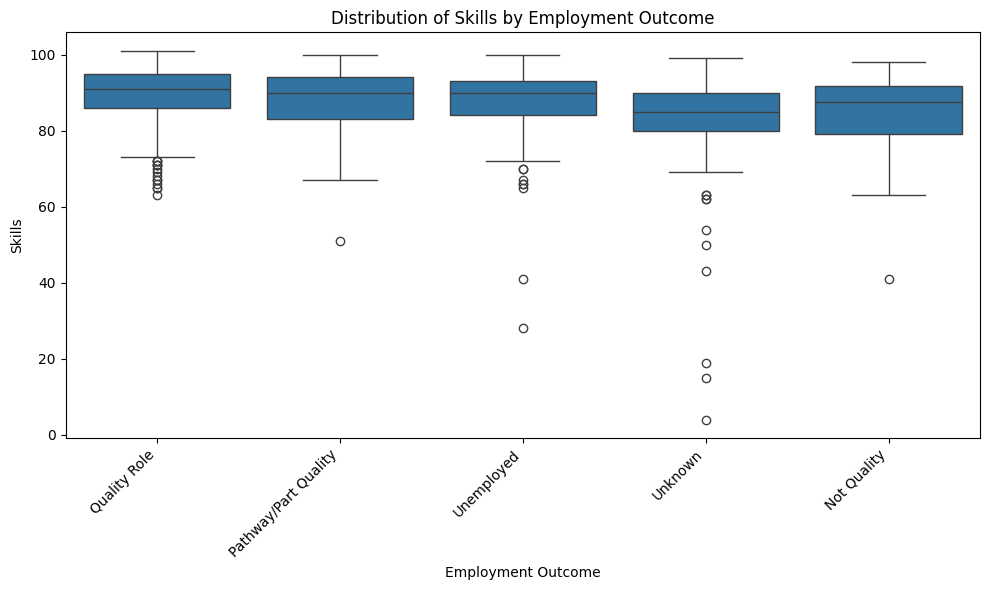

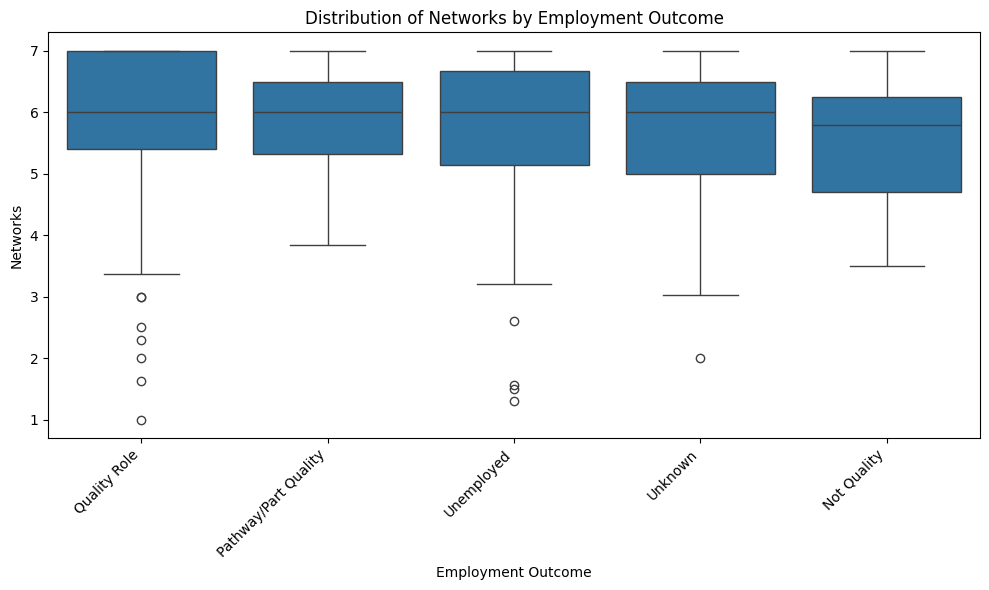

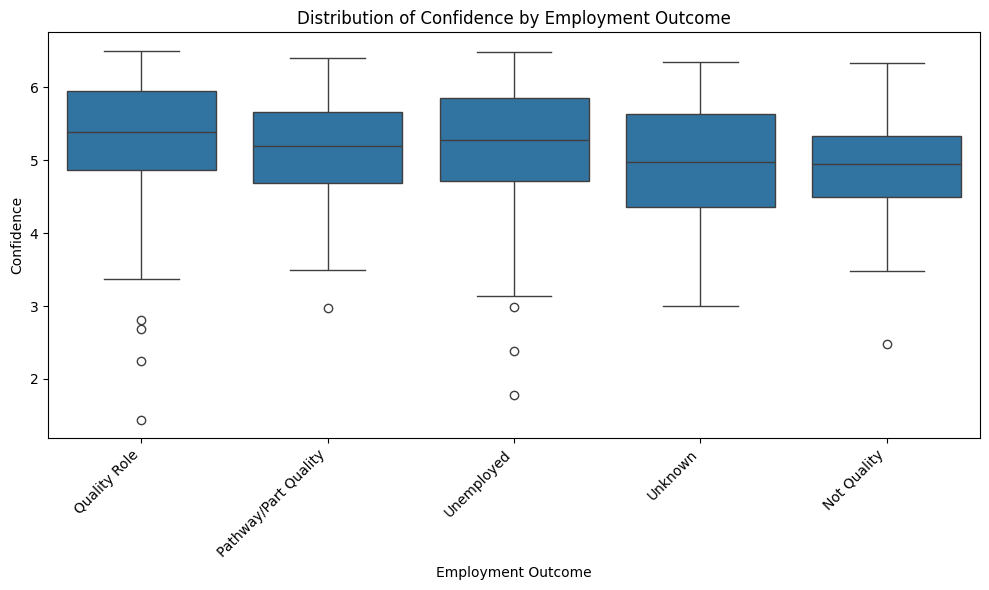

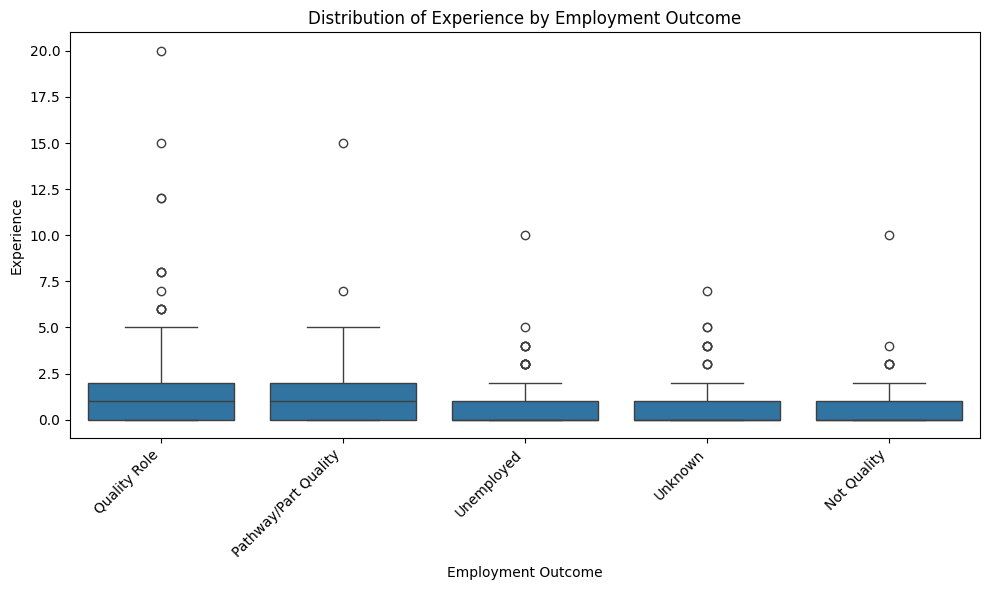

In [ ]:
print("\n" + "=" * 80)
print("STEP 3: DESCRIPTIVE STATISTICS BY OUTCOME")
print("=" * 80)

print("\nMean scores by employment outcome:")
comparison = data_prepared.groupby('employment_outcome')[factor_scores].mean()
print(comparison)

# Note: Difference calculation is not meaningful for multi-categorical outcome
# print("\nDifference (Quality - Not Quality):")
# diff = comparison.loc['Quality Role'] - comparison.loc['Not Quality Role']
# print(diff)

# Visualize distributions with boxplots
print("\nVisualizing distributions with boxplots:")

for factor in factor_scores:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='employment_outcome', y=factor, data=data_prepared)
    plt.title(f'Distribution of {factor.replace("_score", "").title()} by Employment Outcome')
    plt.xlabel('Employment Outcome')
    plt.ylabel(factor.replace("_score", "").title())
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [ ]:
print("\n" + "=" * 80)
print("POST-HOC ANALYSIS (TUKEY'S HSD) FOR SKILLS")
print("=" * 80)

from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd

# Load the data (re-loading to ensure data_prepared is available)
df = pd.read_csv('ADResearch_FY26Task_dataset.csv')

# Create categorical outcome
df['employment_outcome'] = df['employment']

# Define the four factors
df['skills_score'] = df['grade']
df['networks_score'] = df[['post_netdiv_avg', 'post_netstren_avg']].mean(axis=1)
df['confidence_score'] = df[['post_cse_avg', 'post_fit_avg',
                                'post_jse_avg', 'post_nse_avg']].mean(axis=1)
df['experience_score'] = df['internship']

factor_scores = ['skills_score', 'networks_score', 'confidence_score', 'experience_score']

# Prepare the dataset (keeping all rows and handling missing in analysis)
data_prepared = df[factor_scores + ['employment_outcome']].copy()


# Perform Tukey's HSD test for Skills, dropping NaNs
tukey_skills = pairwise_tukeyhsd(endog=data_prepared['skills_score'].dropna(),
                                  groups=data_prepared['employment_outcome'][data_prepared['skills_score'].notna()],
                                  alpha=0.05)

print(tukey_skills)


POST-HOC ANALYSIS (TUKEY'S HSD) FOR SKILLS
              Multiple Comparison of Means - Tukey HSD, FWER=0.05               
       group1               group2        meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------------
         Not Quality Pathway/Part Quality   2.9343 0.0858 -0.2406  6.1092  False
         Not Quality         Quality Role   4.4767 0.0002  1.6326  7.3208   True
         Not Quality           Unemployed   2.2998 0.2898 -0.9165  5.5161  False
         Not Quality              Unknown  -2.0464 0.4215 -5.2955  1.2027  False
Pathway/Part Quality         Quality Role   1.5424 0.1989 -0.4154  3.5002  False
Pathway/Part Quality           Unemployed  -0.6345  0.956  -3.102  1.8331  False
Pathway/Part Quality              Unknown  -4.9807    0.0 -7.4908 -2.4706   True
        Quality Role           Unemployed  -2.1769 0.0278 -4.2012 -0.1526   True
        Quality Role              Unknown  -6.5231    0.0  -8.599

# STEP 4: MULTINOMIAL LOGISTIC REGRESSION
# ============================================================================

In [ ]:
print("\n" + "=" * 80)
print("STEP 4: MULTINOMIAL LOGISTIC REGRESSION")
print("=" * 80)

# Drop rows where the outcome is 'Unknown' as multinomial logistic regression requires known outcomes
data_regression = data_prepared[data_prepared['employment_outcome'] != 'Unknown'].copy()

# Drop rows with any missing factor scores for the regression model
data_regression.dropna(subset=factor_scores, inplace=True)

print(f"\nDataset for Regression: {len(data_regression)} observations")
print(f"Missing values per factor in regression dataset:")
print(data_regression[factor_scores].isnull().sum())
print(f"Missing values in employment outcome in regression dataset: {data_regression['employment_outcome'].isnull().sum()}")


X = data_regression[factor_scores]
y = data_regression['employment_outcome']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the Multinomial Logistic Regression model
# We need to import the LogisticRegressionCV and set multi_class='multinomial' and solver='lbfgs'
from sklearn.linear_model import LogisticRegressionCV

# Use LogisticRegressionCV for cross-validation and to find the best C
model = LogisticRegressionCV(multi_class='multinomial', solver='lbfgs', random_state=42, cv=5, max_iter=1000)
model.fit(X_scaled, y)


print(f"\nMultinomial Logistic Regression Model Accuracy: {model.score(X_scaled, y):.4f}")
print(f"Sample size for regression: {len(data_regression)}")

print("\nCoefficients and Odds Ratios relative to the reference category:")
# The coefficients are relative to the first class in alphabetical order by default
reference_category = model.classes_[0]
print(f"Reference Category: {reference_category}")

multinomial_results = []

# The coefficients are stored in model.coef_ (shape is n_classes - 1, n_features)
# The classes are stored in model.classes_

# Iterate through classes, excluding the reference class
for i, target_class in enumerate(model.classes_[1:]):
    print(f"\n--- Relative to {reference_category} (Outcome = {target_class}) ---")
    for j, factor in enumerate(factor_scores):
        coef = model.coef_[i, j]
        odds_ratio = np.exp(coef)
        factor_name = factor.replace('_score', '').title()

        multinomial_results.append({
            'Target_Outcome': target_class,
            'Reference_Outcome': reference_category,
            'Factor': factor_name,
            'Coefficient': coef,
            'Odds_Ratio': odds_ratio
        })
        print(f"  {factor_name:15s}: Coefficient = {coef:.4f}, Odds Ratio = {odds_ratio:.4f}")

multinomial_results_df = pd.DataFrame(multinomial_results)


STEP 4: MULTINOMIAL LOGISTIC REGRESSION

Dataset for Regression: 732 observations
Missing values per factor in regression dataset:
skills_score        0
networks_score      0
confidence_score    0
experience_score    0
dtype: int64
Missing values in employment outcome in regression dataset: 0

Multinomial Logistic Regression Model Accuracy: 0.6038
Sample size for regression: 732

Coefficients and Odds Ratios relative to the reference category:
Reference Category: Not Quality

--- Relative to Not Quality (Outcome = Pathway/Part Quality) ---
  Skills         : Coefficient = -0.0026, Odds Ratio = 0.9974
  Networks       : Coefficient = -0.0018, Odds Ratio = 0.9982
  Confidence     : Coefficient = -0.0020, Odds Ratio = 0.9980
  Experience     : Coefficient = -0.0007, Odds Ratio = 0.9993

--- Relative to Not Quality (Outcome = Quality Role) ---
  Skills         : Coefficient = -0.0001, Odds Ratio = 0.9999
  Networks       : Coefficient = -0.0003, Odds Ratio = 0.9997
  Confidence     : Coef

# STEP 5: COMPREHENSIVE SUMMARY AND INTERPRETATION
# ============================================================================

In [ ]:
print("\n" + "=" * 80)
print("STEP 5: COMPREHENSIVE SUMMARY AND INTERPRETATION")
print("=" * 80)

print("\nANOVA Results (Analysis with Multi-Categorical Outcome):")
print(anova_results_df)

print("\nDescriptive Statistics (Mean scores by employment outcome):")
print(comparison)

print("\nMultinomial Logistic Regression Results (Coefficients and Odds Ratios relative to Not Quality):")
print(multinomial_results_df)

print("\n" + "=" * 80)
print("KEY FINDINGS AND INTERPRETATION")
print("=" * 80)

print("\nBased on the ANOVA results, all factors (Skills, Networks, Confidence, and Experience) show statistically significant differences in mean scores across the different employment outcomes (p < 0.05).")

print("\nThe descriptive statistics show the mean scores for each factor within each employment outcome category. This helps to understand the direction of the differences observed in the ANOVA.")

print("\nThe multinomial logistic regression results provide insights into the relationship between each factor and the likelihood of being in a particular outcome category relative to the 'Not Quality' outcome, while controlling for other factors.")

print("\nInterpretation of Odds Ratios:")
print("- An Odds Ratio > 1 indicates that for a one-unit increase in the factor, the odds of being in the target outcome category (vs. the reference category) increase.")
print("- An Odds Ratio < 1 indicates that for a one-unit increase in the factor, the odds of being in the target outcome category (vs. the reference category) decrease.")

print("\nFurther interpretation should consider the magnitude and direction of the coefficients and odds ratios for each factor across the different outcome comparisons.")

# You can add more specific interpretations here based on the multinomial_results_df
# For example:
# print("\nSpecific Interpretation Examples:")
# for index, row in multinomial_results_df.iterrows():
#     print(f"- For {row['Factor']}, the odds of being in {row['Target_Outcome']} compared to {row['Reference_Outcome']} are {row['Odds_Ratio']:.4f} times higher/lower (based on OR > or < 1) for each unit increase in the factor.")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)


STEP 5: COMPREHENSIVE SUMMARY AND INTERPRETATION

ANOVA Results (Analysis with Multi-Categorical Outcome):
       Factor  F_statistic       p_value Significant
0      Skills    20.816023  1.301893e-16         Yes
1    Networks     3.458479  8.184873e-03         Yes
2  Confidence     7.226268  9.948041e-06         Yes
3  Experience     3.348994  9.879651e-03         Yes

Descriptive Statistics (Mean scores by employment outcome):
                      skills_score  networks_score  confidence_score  \
employment_outcome                                                     
Not Quality              84.961538        5.508176          4.916523   
Pathway/Part Quality     87.895833        5.830916          5.131298   
Quality Role             89.438221        5.951417          5.310049   
Unemployed               87.261364        5.719290          5.159373   
Unknown                  82.915152        5.698469          4.963969   

                      experience_score  
employment_outcome  

In [ ]:
# STEP 6: COMBINED LOGISTIC REGRESSION (ON COMPLETE DATA)
# ============================================================================

print("\n" + "=" * 80)
print("STEP 6: COMBINED LOGISTIC REGRESSION")
print("=" * 80)

# Create a binary outcome variable 'quality_role' (1 if 'Quality Role', 0 otherwise)
data_complete = data_prepared.copy()
data_complete['quality_role'] = (data_complete['employment_outcome'] == 'Quality Role').astype(int)

# Drop rows with missing factor scores for this analysis
data_complete.dropna(subset=factor_scores, inplace=True)


X_all = data_complete[factor_scores]
y_all = data_complete['quality_role']

scaler_all = StandardScaler()
X_all_scaled = scaler_all.fit_transform(X_all)

# Use a standard Logistic Regression model for binary outcome
model_all = LogisticRegression(random_state=42)
model_all.fit(X_all_scaled, y_all)

print(f"\nCombined Model Accuracy: {model_all.score(X_all_scaled, y_all):.4f}")
print(f"Sample size: {len(data_complete)}")

print("\nStandardized Coefficients:")
combined_results = []
for i, factor in enumerate(factor_scores):
    coef = model_all.coef_[0][i]
    odds_ratio = np.exp(coef)
    factor_name = factor.replace('_score', '').title()

    combined_results.append({
        'Factor': factor_name,
        'Coefficient': coef,
        'Odds_Ratio': odds_ratio,
        'Abs_Coefficient': abs(coef)
    })
    print(f"  {factor_name:15s}: {coef:.4f} (OR: {odds_ratio:.4f})")

combined_results_df = pd.DataFrame(combined_results)
combined_results_df = combined_results_df.sort_values('Abs_Coefficient', ascending=False)


STEP 6: COMBINED LOGISTIC REGRESSION

Combined Model Accuracy: 0.6000
Sample size: 830

Standardized Coefficients:
  Skills         : 0.2991 (OR: 1.3487)
  Networks       : -0.0237 (OR: 0.9766)
  Confidence     : 0.2671 (OR: 1.3062)
  Experience     : 0.2258 (OR: 1.2534)


In [ ]:
# STEP 7: COMPREHENSIVE SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("COMPREHENSIVE SUMMARY OF RESULTS")
print("=" + "=" * 80)

# Merge all results
summary = correlation_results_df.copy()
summary = summary.merge(
    results_df[['Factor', 'Difference', 'p_value', 'Cohens_d']],
    on='Factor'
)
summary = summary.merge(
    individual_results_df[['Factor', 'Coefficient', 'Odds_Ratio']],
    on='Factor',
    suffixes=('', '_individual')
)
summary = summary.merge(
    combined_results_df[['Factor', 'Coefficient', 'Odds_Ratio']],
    on='Factor',
    suffixes=('_individual', '_combined')
)

# Rename columns for clarity
summary.columns = ['Factor', 'Pearson_r', 'Mean_Diff', 'p_value', 'Cohens_d',
                   'Coef_Individual', 'OR_Individual', 'Coef_Combined', 'OR_Combined']

# Sort by correlation (descending)
summary = summary.sort_values('Pearson_r', ascending=False)

print("\nComplete Results Table:")
print("=" * 120)
print(f"{'Factor':<12} {'Corr(r)':<10} {'Mean Diff':<12} {'p-value':<10} {'Cohen_d':<10} "
      f"{'Coef_Indiv':<12} {'Coef_Comb':<12}")
print("=" * 120)

for _, row in summary.iterrows():
    sig = '***' if row['p_value'] < 0.001 else '**' if row['p_value'] < 0.01 else '*' if row['p_value'] < 0.05 else ''
    print(f"{row['Factor']:<12} {row['Pearson_r']:<10.4f} {row['Mean_Diff']:<12.3f} "
          f"{row['p_value']:<10.4f}{sig:<3} {row['Cohens_d']:<10.3f} "
          f"{row['Coef_Individual']:<12.4f} {row['Coef_Combined']:<12.4f}")


COMPREHENSIVE SUMMARY OF RESULTS

Complete Results Table:
Factor       Corr(r)    Mean Diff    p-value    Cohen_d    Coef_Indiv   Coef_Comb   


# STEP 7A: CORRELATION ANALYSIS
# ============================================================================

In [ ]:
print("\n" + "=" * 80)
print("STEP 7A: CORRELATION ANALYSIS")
print("=" * 80)

# We need to use the data_complete dataset which has the binary outcome 'quality_role'
# Drop rows with missing factor scores for this analysis
data_corr = data_complete.copy()
data_corr.dropna(subset=factor_scores + ['quality_role'], inplace=True)

# Calculate correlations between factor scores and the binary outcome 'quality_role'
correlation_results = data_corr[factor_scores + ['quality_role']].corr()['quality_role'].drop('quality_role')

print("\nPearson Correlation with Quality Role:")
print(correlation_results)

correlation_results_df = correlation_results.reset_index()
correlation_results_df.columns = ['Factor', 'Pearson_r']


STEP 7A: CORRELATION ANALYSIS

Pearson Correlation with Quality Role:
skills_score        0.156934
networks_score      0.109311
confidence_score    0.157457
experience_score    0.117882
Name: quality_role, dtype: float64


# STEP 7B: COMPARISON OF MEANS (t-tests or similar for binary outcome)
# ============================================================================

In [ ]:
print("\n" + "=" * 80)
print("STEP 7B: COMPARISON OF MEANS")
print("=" * 80)

# We will compare the means of each factor between 'Quality Role' (1) and 'Not Quality Role' (0)
# using independent samples t-tests, assuming equal variances for simplicity.
# We will use the data_complete dataset which has the binary outcome 'quality_role'
# Drop rows with missing factor scores for this analysis
data_ttest = data_complete.copy()
data_ttest.dropna(subset=factor_scores + ['quality_role'], inplace=True)

results = []

for factor in factor_scores:
    # Separate data into two groups based on the binary outcome
    group1 = data_ttest[data_ttest['quality_role'] == 0][factor].dropna()
    group2 = data_ttest[data_ttest['quality_role'] == 1][factor].dropna()

    # Check if both groups have enough data for t-test (at least 2 samples each)
    if len(group1) >= 2 and len(group2) >= 2:
        # Perform independent samples t-test
        t_statistic, p_value = stats.ttest_ind(group1, group2, equal_var=True, nan_policy='omit')

        # Calculate Cohen's d (effect size)
        mean1, mean2 = np.mean(group1), np.mean(group2)
        std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1) # ddof=1 for sample standard deviation
        pooled_std = np.sqrt(((len(group1) - 1) * std1**2 + (len(group2) - 1) * std2**2) / (len(group1) + len(group2) - 2))
        cohens_d = (mean2 - mean1) / pooled_std if pooled_std != 0 else np.nan

        difference = mean2 - mean1

        significant = 'Yes' if p_value < 0.05 else 'No'
    else:
        t_statistic, p_value, cohens_d, difference = np.nan, np.nan, np.nan, np.nan
        significant = 'N/A'

    factor_name = factor.replace('_score', '').title()

    results.append({
        'Factor': factor_name,
        'Mean_Group_0': np.mean(group1),
        'Mean_Group_1': np.mean(group2),
        'Difference': difference,
        'T_statistic': t_statistic,
        'p_value': p_value,
        'Cohens_d': cohens_d,
        'Significant': significant
    })

results_df = pd.DataFrame(results)

print("\nComparison of Means (Quality Role vs. Not Quality Role):")
print(results_df[['Factor', 'Mean_Group_0', 'Mean_Group_1', 'Difference', 'p_value', 'Cohens_d', 'Significant']])


STEP 7B: COMPARISON OF MEANS

Comparison of Means (Quality Role vs. Not Quality Role):
       Factor  Mean_Group_0  Mean_Group_1  Difference   p_value  Cohens_d  \
0      Skills     87.788660     90.171946    2.383286  0.000006  0.318097   
1    Networks      5.721435      5.950641    0.229206  0.001611  0.220142   
2  Confidence      5.070706      5.322573    0.251867  0.000005  0.319184   
3  Experience      0.971649      1.404977    0.433328  0.000667  0.237637   

  Significant  
0         Yes  
1         Yes  
2         Yes  
3         Yes  


# STEP 7C: INDIVIDUAL LOGISTIC REGRESSION MODELS
# ============================================================================

In [ ]:
print("\n" + "=" * 80)
print("STEP 7C: INDIVIDUAL LOGISTIC REGRESSION MODELS")
print("=" * 80)

# We will fit individual logistic regression models for each factor predicting 'quality_role'
# We will use the data_complete dataset which has the binary outcome 'quality_role'
# Drop rows with missing factor scores for this analysis
data_lr_individual = data_complete.copy()
data_lr_individual.dropna(subset=factor_scores + ['quality_role'], inplace=True)


individual_results = []

for factor in factor_scores:
    X_individual = data_lr_individual[[factor]]
    y_individual = data_lr_individual['quality_role']

    # Scale the feature
    scaler_individual = StandardScaler()
    X_individual_scaled = scaler_individual.fit_transform(X_individual)

    # Fit the Logistic Regression model
    model_individual = LogisticRegression(random_state=42)
    model_individual.fit(X_individual_scaled, y_individual)

    coef = model_individual.coef_[0][0]
    odds_ratio = np.exp(coef)
    factor_name = factor.replace('_score', '').title()

    individual_results.append({
        'Factor': factor_name,
        'Coefficient': coef,
        'Odds_Ratio': odds_ratio
    })
    print(f"\nLogistic Regression for {factor_name}:")
    print(f"  Coefficient: {coef:.4f}, Odds Ratio: {odds_ratio:.4f}")

individual_results_df = pd.DataFrame(individual_results)


STEP 7C: INDIVIDUAL LOGISTIC REGRESSION MODELS

Logistic Regression for Skills:
  Coefficient: 0.3297, Odds Ratio: 1.3905

Logistic Regression for Networks:
  Coefficient: 0.2202, Odds Ratio: 1.2463

Logistic Regression for Confidence:
  Coefficient: 0.3214, Odds Ratio: 1.3790

Logistic Regression for Experience:
  Coefficient: 0.2709, Odds Ratio: 1.3112


In [ ]:
# STEP 8: KEY FINDINGS AND INTERPRETATION
# ============================================================================

print("\n" + "=" * 80)
print("KEY FINDINGS")
print("=" * 80)

# Recreate the summary DataFrame to ensure it's available
# Merge all results

# Standardize the 'Factor' column names before merging
correlation_results_df['Factor'] = correlation_results_df['Factor'].str.replace('_score', '').str.title()
results_df['Factor'] = results_df['Factor'].str.replace('_score', '').str.title()
individual_results_df['Factor'] = individual_results_df['Factor'].str.replace('_score', '').str.title()
combined_results_df['Factor'] = combined_results_df['Factor'].str.replace('_score', '').str.title()


summary = correlation_results_df.copy()
summary = summary.merge(
    results_df[['Factor', 'Difference', 'p_value', 'Cohens_d']],
    on='Factor'
)
summary = summary.merge(
    individual_results_df[['Factor', 'Coefficient', 'Odds_Ratio']],
    on='Factor',
    suffixes=('', '_individual')
)
summary = summary.merge(
    combined_results_df[['Factor', 'Coefficient', 'Odds_Ratio']],
    on='Factor',
    suffixes=('_individual', '_combined')
)

# Rename columns for clarity
summary.columns = ['Factor', 'Pearson_r', 'Mean_Diff', 'p_value', 'Cohens_d',
                   'Coef_Individual', 'OR_Individual', 'Coef_Combined', 'OR_Combined']

# Sort by correlation (descending)
summary = summary.sort_values('Pearson_r', ascending=False)

print("\nComplete Results Table:")
print("=" * 120)
print(f"{'Factor':<12} {'Corr(r)':<10} {'Mean Diff':<12} {'p-value':<10} {'Cohen_d':<10} "
      f"{'Coef_Indiv':<12} {'Coef_Comb':<12}")
print("=" * 120)

for _, row in summary.iterrows():
    sig = '***' if row['p_value'] < 0.001 else '**' if row['p_value'] < 0.01 else '*' if row['p_value'] < 0.05 else ''
    print(f"{row['Factor']:<12} {row['Pearson_r']:<10.4f} {row['Mean_Diff']:<12.3f} "
          f"{row['p_value']:<10.4f}{sig:<3} {row['Cohens_d']:<10.3f} "
          f"{row['Coef_Individual']:<12.4f} {row['Coef_Combined']:<12.4f}")


KEY FINDINGS

Complete Results Table:
Factor       Corr(r)    Mean Diff    p-value    Cohen_d    Coef_Indiv   Coef_Comb   
Confidence   0.1575     0.252        0.0000    *** 0.319      0.3214       0.2671      
Skills       0.1569     2.383        0.0000    *** 0.318      0.3297       0.2991      
Experience   0.1179     0.433        0.0007    *** 0.238      0.2709       0.2258      
Networks     0.1093     0.229        0.0016    **  0.220      0.2202       -0.0237     
